In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

In [3]:
# load the dataset
import zipfile

path = "data.zip"
with zipfile.ZipFile(path, "r") as z:
    file_list = z.namelist()
    print("ZIP:", file_list) 
    # load the recipes data
    with z.open("recipes.csv") as f:
        recipes = pd.read_csv(f)
recipes.head()


ZIP: ['recipes.csv', 'recipes.parquet', 'reviews.csv', 'reviews.parquet']


,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


## **1. Data Exploration**

In [4]:
print(recipes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 13  RecipeIngredie

In [26]:
print(recipes.isnull().sum())

RecipeId                           0
Name                               0
AuthorId                           0
AuthorName                         0
CookTime                       82545
PrepTime                           0
TotalTime                          0
DatePublished                      0
Description                        5
Images                             1
RecipeCategory                   751
Keywords                       17237
RecipeIngredientQuantities         3
RecipeIngredientParts              0
AggregatedRating              253223
ReviewCount                   247489
Calories                           0
FatContent                         0
SaturatedFatContent                0
CholesterolContent                 0
SodiumContent                      0
CarbohydrateContent                0
FiberContent                       0
SugarContent                       0
ProteinContent                     0
RecipeServings                182911
RecipeYield                   348071
R

In [30]:
## select those columns we care about
selected_columns = ['RecipeId','Name','Calories', 'FatContent', 'SaturatedFatContent','CholesterolContent', 'SodiumContent', 'CarbohydrateContent','FiberContent', 'SugarContent', 'ProteinContent','RecipeIngredientParts','RecipeInstructions']

data = recipes[selected_columns]

In [31]:
data.head()

,RecipeId,Name,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeIngredientParts,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,"c(""blueberries"", ""granulated sugar"", ""vanilla ...","c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,"c(""saffron"", ""milk"", ""hot green chili peppers""...","c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,"c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...","c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,"c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...","c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,"c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...","c(""Mix everything together and bring to a boil..."


In [32]:
print(data.isnull().sum())


RecipeId                 0
Name                     0
Calories                 0
FatContent               0
SaturatedFatContent      0
CholesterolContent       0
SodiumContent            0
CarbohydrateContent      0
FiberContent             0
SugarContent             0
ProteinContent           0
RecipeIngredientParts    0
RecipeInstructions       0
dtype: int64


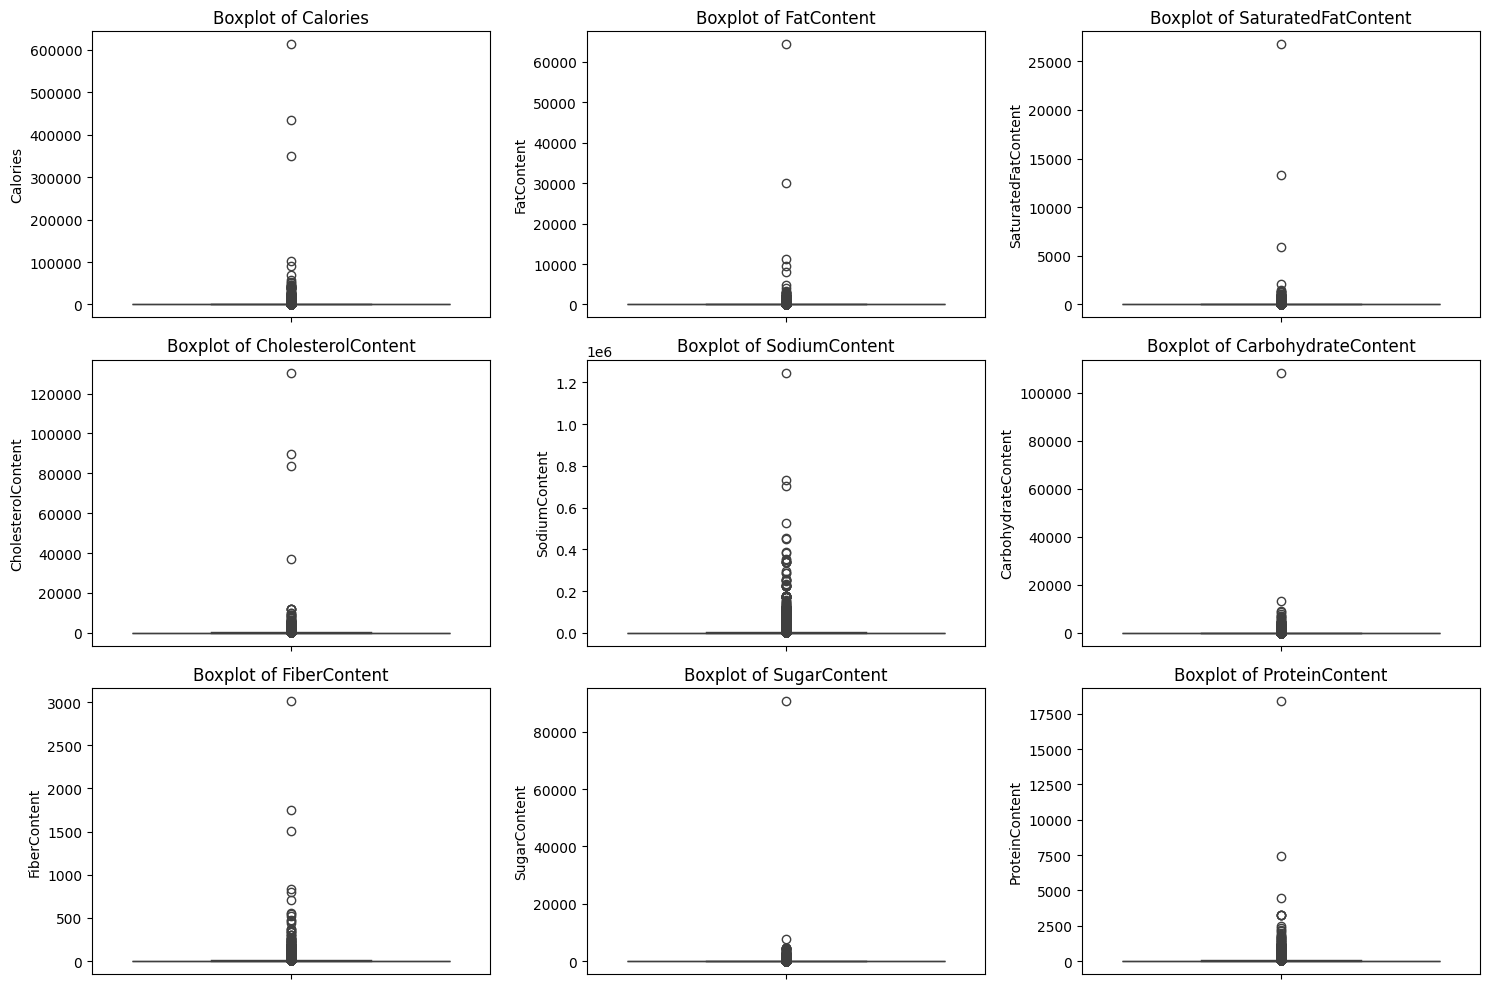

In [33]:
fields_of_interest = [
    "Calories", "FatContent", "SaturatedFatContent", "CholesterolContent",
    "SodiumContent", "CarbohydrateContent", "FiberContent", "SugarContent",
    "ProteinContent"
]

plt.figure(figsize=(15, 10))
for i, field in enumerate(fields_of_interest, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=data[field])
    plt.title(f"Boxplot of {field}")
plt.tight_layout()
plt.show()

### We can see from BoxPlot that the data is **serverely affected by the outlier**

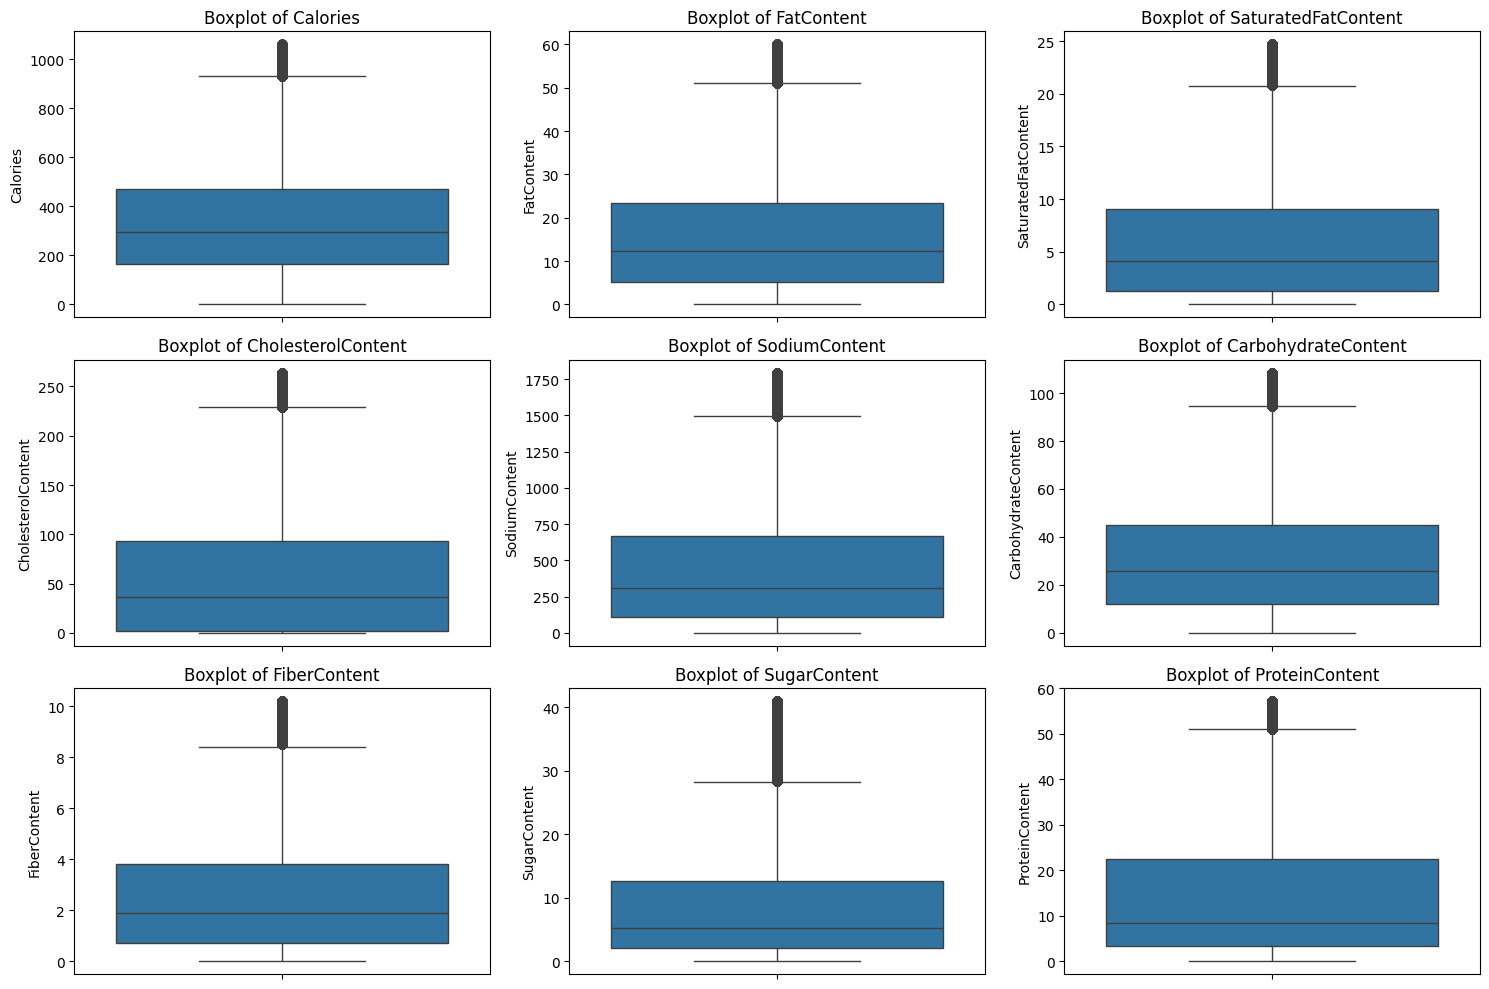

In [34]:
# remove the outlier by IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)][column]

## plot again
plt.figure(figsize=(15, 10))
for i, field in enumerate(fields_of_interest, 1):
    filtered_data = remove_outliers(data, field)
    plt.subplot(3, 3, i)
    sns.boxplot(filtered_data)
    plt.title(f"Boxplot of {field}")
plt.tight_layout()
plt.show()


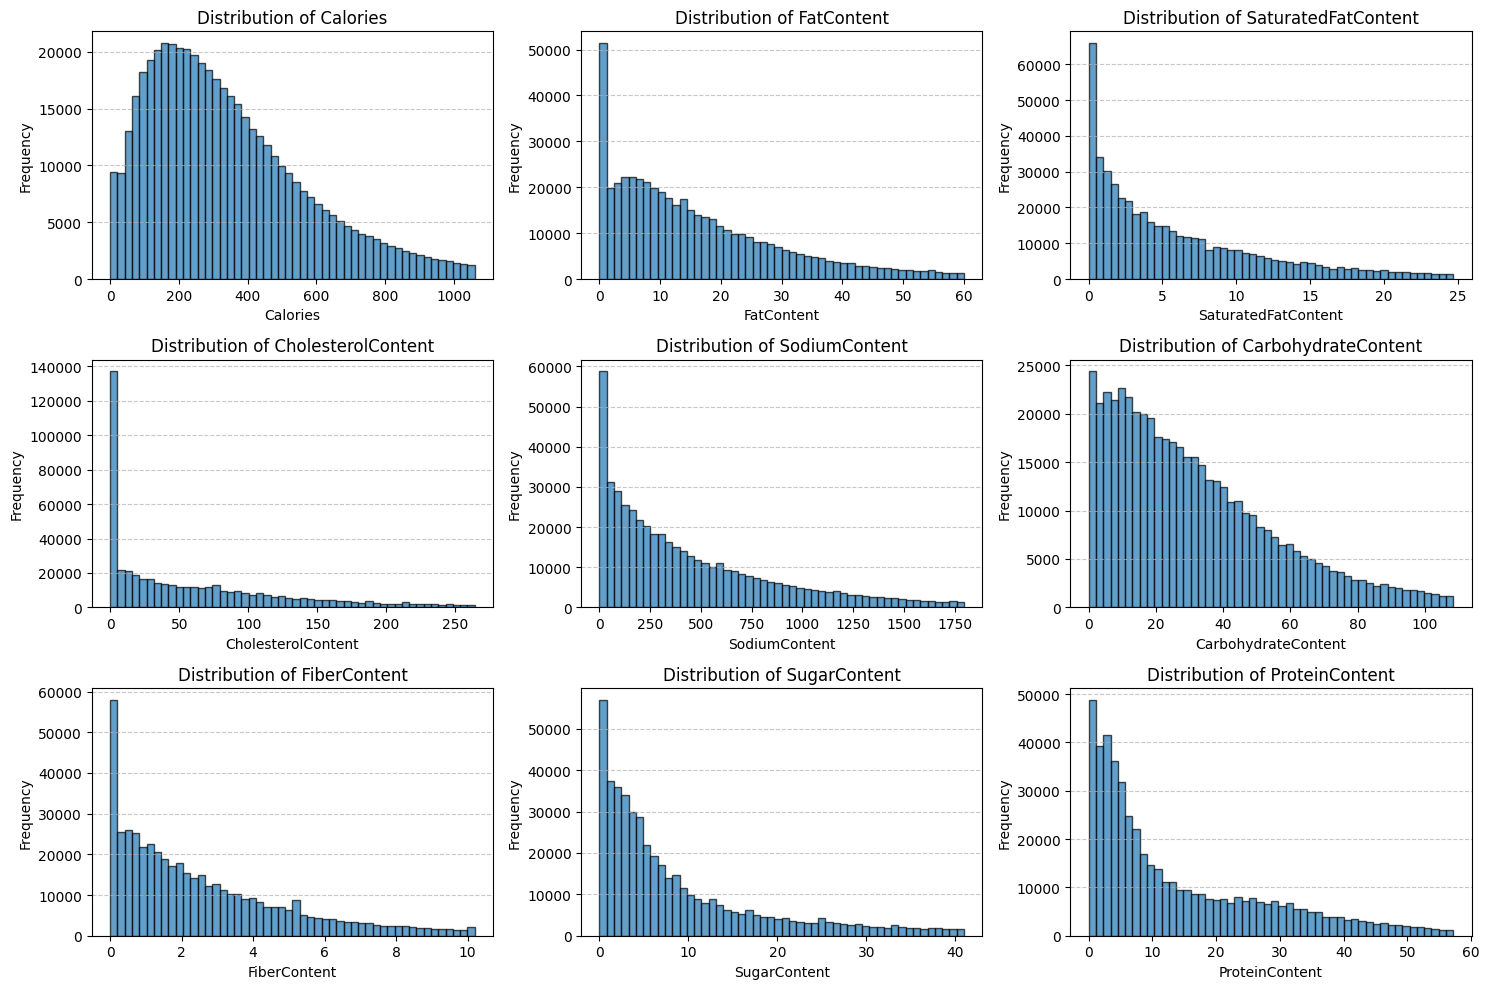

In [35]:
# plot distribution

plt.figure(figsize=(15, 10))
for i, field in enumerate(fields_of_interest, 1):
    plt.subplot(3, 3, i)
    filtered_data = remove_outliers(data, field) 
    plt.hist(filtered_data, bins=50, edgecolor="black", alpha=0.7)
    plt.title(f"Distribution of {field}")
    plt.xlabel(field)
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### **Data Distribution Analysis**

#### **Skewed Distribution (Right-Skewed / Long-Tailed Distribution)**  
- **Fat Content (`FatContent`), Carbohydrates (`CarbohydrateContent`), and Protein (`ProteinContent`)** exhibit a **right-skewed distribution**, where most values are concentrated in a lower range, but some extend significantly higher.  
- This indicates that **most recipes have relatively low nutritional values**, but there are still some **high-calorie, high-fat, or high-protein** recipes.

#### **Cholesterol (`CholesterolContent`) and Sodium (`SodiumContent`)**  
- **Cholesterol (`CholesterolContent`)**: The majority of recipes contain little to no cholesterol, but some have significantly higher values, likely from **high-cholesterol foods such as meat, egg yolks, etc.**  
- **Sodium (`SodiumContent`)**: This also follows a long-tail distribution, meaning **most recipes have low sodium content**, but a few contain **very high sodium levels**, typically **processed or preserved foods**.

#### **Sugar (`SugarContent`) and Fiber (`FiberContent`)**  
- **Sugar (`SugarContent`) and Fiber (`FiberContent`)** both show a **right-skewed distribution**, which aligns with expectations.  
- **Most recipes contain low sugar**, but some, such as **desserts and beverages,** have high sugar content.  
- **Fiber content is relatively low**, suggesting that many recipes might be made from **refined foods or meats**.

#### **Calories (`Calories`)**  
- The overall distribution appears **reasonable**, with most recipes containing **0-600 calories**, which is typical for nutritional distribution.  
- However, some **high-calorie recipes** still exist, likely corresponding to **cakes, fast food, or other energy-dense meals**.

## **2. Build the Recommendation System**

In [36]:
## import libaries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [37]:
fields_of_interest = [
    "Calories","FatContent", "SaturatedFatContent", "CholesterolContent",
    "SodiumContent", "CarbohydrateContent", "FiberContent", "SugarContent",
    "ProteinContent"
]


def preprocess_data(df):
    df = df.copy()
    # remove the outliers
    for col in fields_of_interest:
        df[col] = remove_outliers(df, col)
    # fill in the NA value
    df[fields_of_interest] = df[fields_of_interest].fillna(df[fields_of_interest].median())
    
    return df


In [38]:
# recommendation function
# consider there are large amount of data, directly compute the whole similarity matrix could be time-consuming
# use KNN to facilitate the search
def recommend_recipes_knn(df, user_preferences, top_n=5):
    """
    Based on user's nutrients need, recommend the most similar recipe
    user_preferences: dict with user's targeted nutrient, e.g:
    {
        "Calories": 0.3,
        "FatContent": 0.2,
        "ProteinContent": 0.8,
        "SugarContent": 0.1
    }
    """
    # convert into DataFrame
    user_df = pd.DataFrame([user_preferences])
    
    # scaling
    scaler = StandardScaler()
    user_df[fields_of_interest] = scaler.fit_transform(user_df[fields_of_interest])


    # train the KNN model(with cosine similarity)
    knn = NearestNeighbors(n_neighbors=top_n, metric="cosine")
    knn.fit(df[fields_of_interest])

    # find the most common recipes
    distances, indices = knn.kneighbors(user_df)

    # return recommended recipes
    return df.iloc[indices[0]][["Name"] + fields_of_interest]

In [39]:
data = preprocess_data(data)

In [40]:
## test case
user_preferences = {
    "Calories": 500,
    "FatContent": 0.2,
    "SaturatedFatContent": 0.1,
    "CholesterolContent": 0.1,
    "SodiumContent": 0.2,
    "CarbohydrateContent": 0.3,
    "FiberContent": 0.5,
    "SugarContent": 0.1,
    "ProteinContent": 0.8
}
recommended_recipes = recommend_recipes_knn(data, user_preferences, top_n=5)
## recommend based on KNN with cosine similarity
recommended_recipes

,Name,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
348345,Cream of Jalapeno Soup,442.2,38.9,24.0,130.6,324.7,13.2,1.2,4.3,11.8
348343,Coleslaw With Old Bay Seasoning,159.1,10.0,1.5,7.6,243.7,17.1,4.0,7.4,2.2
348347,Coconut Rice Pudding,515.5,18.5,16.1,62.0,188.6,84.7,1.5,5.3,5.1
348344,Mustard Chicken &amp; Potato Smash (21 Day Won...,528.1,3.3,0.7,75.7,117.6,91.4,1.9,2.4,42.1
348349,Sweet Potato Chili,562.6,21.6,7.3,77.1,1017.1,59.6,1.9,10.3,36.1


### Consider the dataset is large(over 500K entries), we can also use **Faiss** to expedite the searching process

In [16]:
import faiss

# construct faiss index
d = len(fields_of_interest)  # dimension
index = faiss.IndexFlatL2(d)  # recommned based on L2 distance
index.add(np.array(recipes[fields_of_interest], dtype=np.float32))

# find the neareast top 5 recipe
D, I = index.search(np.array([list(user_preferences.values())], dtype=np.float32), 5)

# result
recommended_recipes = data.iloc[I[0]]
# recommend based on faiss with L2 distance
recommended_recipes


ModuleNotFoundError: No module named 'faiss'

#### The above recommendation systems are not that straightforward: 
#### Users usually don't know what's the nutrient in their food
## **--- A MORE DIRECT RECOMMENDATION SYS ---**
### Recommend based on the the Calories need and the ingredients
### **Design on Recommend System**
### Users input their height, weight, health target and the ingredients -- the system will return the TOP K recipes with least Calories based on the gradients

In [41]:
# calculate the calories user body information and the health goal they hold
def calculate_calories(height, weight, goal):
    bmi = weight / (height ** 2)  # BMI
    tdee = weight * 22 * 1.2  # compute BMR
    
    # adjust the calories based on the goal
    if goal == "fat_loss":
        tdee -= 500  # loss weight: lessen 500 kcal
    elif goal == "muscle_gain":
        tdee += 300  # gain weight: add 300 kcal
    return max(tdee, 1200)  # maintain the calories above the threshold

In [42]:
# import re
# from collections import Counter

# def count_word_occurrences(instructions_list):
#     word_counter = Counter()
    
#     for instructions in instructions_list:
#         words = re.findall(r'\b\w+\b', str(instructions).lower())  # 提取单词
#         word_counter.update(words)
    
#     return word_counter

# instructions_list = recipes["RecipeInstructions"].to_numpy()
# word_counter = count_word_occurrences(instructions_list)

In [43]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## re preprocess the recipes["RecipeInstructions"] 
instructions_list = recipes["RecipeIngredientParts"].to_numpy()

def preprocess_instructions(instructions_list):
    return [set(re.findall(r'\b\w+\b', str(instructions).lower())) for instructions in instructions_list]

preprocessed_instructions = preprocess_instructions(instructions_list)

In [44]:
# compute the similarity between user's ingredients and recipes' ingredients
def compute_ingredient_similarity(preprocessed_instructions, user_ingredients):
    user_ingredients_str = " ".join(user_ingredients)

    instructions_list = [" ".join(ingredients) for ingredients in preprocessed_instructions]

    #  CountVectorizer + cosine similarity derive the result
    vectorizer = CountVectorizer()
    text_matrix = vectorizer.fit_transform([user_ingredients_str] + instructions_list) 
    similarity_scores = cosine_similarity(text_matrix[0], text_matrix[1:]).flatten() 

    return similarity_scores

In [ ]:

def recommend_recipes(height, weight, goal, ingredients, recipes, top_n=5):
    # caculate the calories
    target_calories = calculate_calories(height, weight, goal)

    # compute similarity
    similarity_scores = compute_ingredient_similarity(preprocessed_instructions, ingredients)
    data["IngredientSimilarity"] = similarity_scores

    data["CalorieDiff"] = np.abs(data["Calories"] - target_calories)

    # filter the data
    filtered_df = recipes.sort_values(by=["IngredientSimilarity", "CalorieDiff"], ascending=[False, True]).head(top_n)


    if filtered_df.empty:
        return "No matching recipes found. Try different ingredients."

    # return TOP K recipes with least calories based on specific ingredients
    return filtered_df


### Test case
height = 1.75  # height(m)
weight = 65    # weight(kg)
goal = "muscle_gain"  # health target："fat_loss", "muscle_gain", "maintain"
ingredients = {"chicken","carrot","potato"}  # ingredients that user has

# recommend recipes
recommended_recipes = recommend_recipes(height, weight, goal, ingredients, data, top_n=10)


## **2. Check the reviews of recipes**

In [217]:
path = "data.zip"
with zipfile.ZipFile(path, "r") as z:
    file_list = z.namelist()
    print("ZIP:", file_list) 
    # load the reviews data
    with z.open("reviews.csv") as f:
        review = pd.read_csv(f)

ZIP: ['recipes.csv', 'recipes.parquet', 'reviews.csv', 'reviews.parquet']


In [ ]:
selected = review[review["RecipeId"].isin(recommended_recipes["RecipeId"])]
ratings_per_recipe = selected.groupby("RecipeId")["Rating"].apply(list).head(5)
ratings_per_recipe = selected.groupby("RecipeId")["Rating"].agg(['mean', 'count'])

# Calculate a weighted score (you can adjust the factor to balance between the two metrics)
ratings_per_recipe['weighted_score'] = ratings_per_recipe['mean'] * np.log(ratings_per_recipe['count'])
top_3_recipes = ratings_per_recipe.sort_values(by='weighted_score', ascending=False).head(3)
top_3_recipes


,mean,count,weighted_score
RecipeId,,,
43222,4.574074,54,18.245909
152322,4.750000,12,11.803307
52615,4.300000,10,9.901116


In [ ]:
# Trace back the top recipe
top_recipes = ratings_per_recipe.sort_values(by='weighted_score', ascending=False).head(1)
top_recipe_ids = top_3_recipes.index[0]
top_recipes = recommended_recipes[recommended_recipes['RecipeId']==top_recipe_ids]
top_recipes_id = top_recipes["RecipeId"]
top_recipes


,RecipeId,Name,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeIngredientParts,RecipeInstructions,IngredientSimilarity,CalorieDiff
39422,43222,Easiest Chicken Pot Pie,311.4,16.7,4.5,3.7,623.3,35.7,4.5,1.3,5.9,"""chicken""","c(""Mix soup, chicken, vegetables and seasoning...",0.57735,1704.6


In [242]:
top_reviews = review[review['RecipeId'].isin(top_recipes_id)]
top_reviews

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
28305,32791,43222,57680,aniolka,5,I've never made a pot pie before. My husband ...,2002-11-27T17:57:06Z,2002-11-27T17:57:06Z
41673,46765,43222,75449,starrynight,5,This is a simple and tasty dish. I've never m...,2003-03-28T15:11:41Z,2003-03-28T15:11:41Z
46226,51603,43222,41578,Merlot,5,"I also have never made a pot pie before, BUT I...",2003-05-07T15:28:41Z,2003-05-07T15:28:41Z
46752,52152,43222,29014,KeyWee,5,Easy & delicious. I made this up ahead of tim...,2003-05-13T08:28:20Z,2003-05-13T08:28:20Z
67868,74470,43222,64683,luckycloud29,5,what a fantastic way to use leftover chicken! ...,2003-11-07T09:19:51Z,2003-11-07T09:19:51Z
71216,77966,43222,55316,CindyLouWho2,5,This pot pie is great! I used frozen broccoli...,2003-12-03T20:41:19Z,2003-12-03T20:41:19Z
84102,91477,43222,128803,lynettejs,5,"I need meals that taste great, are quick and e...",2004-03-03T08:50:12Z,2004-03-03T08:50:12Z
89411,97056,43222,135229,Charissa McElroy,4,Really good. I added lots of stuff like sour ...,2004-04-06T07:30:12Z,2004-04-06T07:30:12Z
92488,100280,43222,110135,2bizzy,5,Excellent and even better because it's so easy...,2004-04-26T11:55:51Z,2004-04-26T11:55:51Z
135477,145526,43222,106501,daggersmommy,5,I have made this recipe for years. My family ...,2005-01-09T15:33:16Z,2005-01-09T15:33:16Z


In [243]:
top_reviews = review[review['RecipeId'].isin(top_recipes_id)]
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the comments and get word frequencies
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(top_reviews['Review'])

# Get the word frequency counts
word_frequencies = X.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()

# Create a DataFrame to display words and their frequencies
word_freq_df = pd.DataFrame(zip(words, word_frequencies), columns=['Word', 'Frequency'])
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Display the top keywords
word_freq_df.head(10)

,Word,Frequency
89,chicken,46
113,cream,39
395,recipe,35
288,make,30
163,easy,30
353,pie,29
538,used,26
23,added,23
498,thanks,18
369,potato,18


In [252]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import re

def analyze_review_characteristics(reviews_df):
    def clean_text(text):
        text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
        return text
    def get_sentiment(text):
        return TextBlob(str(text)).sentiment.polarity
    
    def detect_suggestion_score(text):
        suggestion_keywords = [
            'would', 'could', 'might', 'suggest', 'recommend', 
            'try', 'maybe', 'perhaps', 'alternative', 'modify',
            'change', 'adjust', 'swap', 'replace', 'improve'
        ]
        
        text_lower = str(text).lower()
        
        suggestion_count = sum(1 for keyword in suggestion_keywords if keyword in text_lower)
        
        has_potential_suggestion = any([
            'next time' in text_lower,
            'i would' in text_lower,
            'i think' in text_lower
        ])
        
        suggestion_score = suggestion_count + (2 if has_potential_suggestion else 0)
        
        return suggestion_score

    reviews_df['Cleaned_Review'] = reviews_df['Review'].apply(clean_text)
    reviews_df['Sentiment_Score'] = reviews_df['Review'].apply(get_sentiment)
    reviews_df['Suggestion_Score'] = reviews_df['Review'].apply(detect_suggestion_score)
    
    most_positive = reviews_df.loc[reviews_df['Sentiment_Score'].idxmax()]
    most_suggestive = reviews_df.loc[reviews_df['Suggestion_Score'].idxmax()]
    
    # Prepare results
    results = {
        'Most Positive Review': {
            'Text': most_positive['Review'],
            'Sentiment Score': most_positive['Sentiment_Score']
        },
        'Most Suggestive Review': {
            'Text': most_suggestive['Review'],
            'Suggestion Score': most_suggestive['Suggestion_Score']
        }
    }
    
    # Detailed Printout
    print("Review Analysis Results:")
    print("\n1. Most Positive Review:")
    print(f"   Sentiment Score: {results['Most Positive Review']['Sentiment Score']:.2f}")
    print(f"   Review: {results['Most Positive Review']['Text']}")
    
    print("\n2. Most Suggestive Review:")
    print(f"   Suggestion Score: {results['Most Suggestive Review']['Suggestion Score']}")
    print(f"   Review: {results['Most Suggestive Review']['Text']}")
    
    return results, reviews_df

In [253]:
review_insights, annotated_reviews = analyze_review_characteristics(top_reviews)

# You can then access specific insights
most_positive_review = review_insights['Most Positive Review']['Text']
most_suggestive_review = review_insights['Most Suggestive Review']['Text']

C:\Users\huang\AppData\Local\Temp\ipykernel_17972\4003365675.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['Cleaned_Review'] = reviews_df['Review'].apply(clean_text)
C:\Users\huang\AppData\Local\Temp\ipykernel_17972\4003365675.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['Sentiment_Score'] = reviews_df['Review'].apply(get_sentiment)
C:\Users\huang\AppData\Local\Temp\ipykernel_17972\4003365675.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Review Analysis Results:

1. Most Positive Review:
   Sentiment Score: 0.85
   Review: Loved thsi. I used 2 layers of puff pastry and it was delicious!

2. Most Suggestive Review:
   Suggestion Score: 6
   Review: Very easy and flavorful recipe.<br/>I did swap out the can of cream of potato soup for a can of cream of chicken soup which added the chickeny goodness a pot pie needs. To replace the potatoes that were omitted from not adding the cream of potato soup I simply cut up a potato into little cubes & boiled them for 12 minutes then added them to my thawed veggie mix. Lastly I added 1/2 of a 10 oz. tub of Philadelphia Cooking Creme (Reduced Fat Italian Cheese & Herb) & mixed it into the whole mess. These little tweaks added a lot of flavor plus a rich & creamy texture that my whole family loved.  I would have given it 5 stars if I didn't have to "adjust" the recipe as much as I did but I will certainly make this again!
